<a href="https://colab.research.google.com/github/Satorumi/Machine-Learning/blob/main/Computational_Drug_Discovery_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Bioinformatics Project - Computational Drug Discovery** **[Part 1]**

Course: [Python for Bioinformatics - Drug Discovery Using Machine Learning and Data Analysis](https://youtu.be/jBlTQjcKuaY)

Building a machine learning model using the ChEMBL bioactivity data.

**Discription:**
- performing Data Collection and Pre-Processing / Descriptor Calculation from the ChEMBL Database.
- Exploratory Data Analysis and compute Statistical Test

### Download Bioactivity Data

In [2]:
!pip install chembl_webresource_client --quiet --use-deprecated=legacy-resolver

In [ ]:
import pandas as pd
from chembl_webresource_client.new_client import new_client

Searching for CoronaVirus Target

In [ ]:
targets = new_client.target
search_target = pd.DataFrame(targets.search('acetylcholinesterase'))

In [ ]:
search_target.head(2)

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P22303', 'xref_name': None, 'xre...",Homo sapiens,Acetylcholinesterase,27.0,False,CHEMBL220,"[{'accession': 'P22303', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Homo sapiens,Cholinesterases; ACHE & BCHE,27.0,False,CHEMBL2095233,"[{'accession': 'P06276', 'component_descriptio...",SELECTIVITY GROUP,9606


In [ ]:
target_id = search_target.target_chembl_id[0]

In [ ]:
activity = new_client.activity
bioactivity_df = activity.filter(target_chembl_id=target_id).filter(standard_type="IC50")
bioactivity_df = pd.DataFrame(bioactivity_df)

In [ ]:
bioactivity_df.head(3)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '19.61', 'le': '0.36', 'lle': '3.32', ...",CHEMBL133897,None,CHEMBL133897,6.12,False,http://www.openphacts.org/units/Nanomolar,252547,=,1,True,=,None,IC50,nM,None,750.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.75
1,None,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '18.57', 'le': '0.38', 'lle': '2.45', ...",CHEMBL336398,None,CHEMBL336398,7.00,False,http://www.openphacts.org/units/Nanomolar,252533,=,1,True,=,None,IC50,nM,None,100.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.1
2,None,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,None,CHEMBL131588,None,CHEMBL131588,None,False,http://www.openphacts.org/units/Nanomolar,252530,>,1,True,>,None,IC50,nM,None,50000.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,50.0


### Data Pre-Processing

####Handling missing and Duplicate data

In [ ]:
bioactivity_df = bioactivity_df[~bioactivity_df.standard_value.isna()]
bioactivity_df = bioactivity_df[~bioactivity_df.canonical_smiles.isna()]

In [ ]:
bioactivity_df.drop_duplicates(['canonical_smiles'], inplace=True)

#### Features Selection

In [ ]:
selected_cols = ['standard_value', 'canonical_smiles', 'molecule_chembl_id']

In [ ]:
bioactivity_df = bioactivity_df[selected_cols]

####Classify status

Label each activity as `active`, `inactive` and `intermediate` refer to `standard_value`


In [ ]:
bioactivity_df['standard_value'] = bioactivity_df['standard_value'].astype(float)

In [ ]:
status = []
for value in bioactivity_df.standard_value:
  if float(value) > 10000:
    status.append('active')
  elif float(value) < 1000:
    status.append('inactive')
  else:
    status.append('intermediate')

In [ ]:
bioactivity_df = bioactivity_df.assign(status=status)

#### Process `canonical_smiles` columns

In [ ]:
bioactivity_df['canonical_smiles'] = bioactivity_df.canonical_smiles.apply(lambda x: max(x.split('.'), key=len))

In [ ]:
bioactivity_df.head(1)

,standard_value,canonical_smiles,molecule_chembl_id,status
0,750.0,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,CHEMBL133897,inactive


####Calculate Descriptors

We will use `smiles` coulumns which contain the molecules data and compute descriptors with `rdkit` library

In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
!bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
!conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-08-03 05:10:34--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   186MB/s    in 0.4s    

2021-08-03 05:10:34 (186 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import numpy as np

In [ ]:
def cal_descriptors(smiles):
  molecule_data = []
  for element in smiles:
    molecule = Chem.MolFromSmiles(element)
    molecule_data.append(molecule)

  base = np.arange(1, 1)
  for i, molecule in enumerate(molecule_data):
    MolWt_desc = Descriptors.MolWt(molecule)
    MolLogP_desc = Descriptors.MolLogP(molecule)
    NumHDonors_desc = Lipinski.NumHDonors(molecule)
    NumHAcceptors_desc = Lipinski.NumHAcceptors(molecule)

    descs = np.array([MolWt_desc, MolLogP_desc,
                      NumHDonors_desc, NumHAcceptors_desc])

    if i == 0:
      base = descs
    else:
      base = np.vstack([base, descs])

  cols_name = ["MW","LogP","NumHDonors","NumHAcceptors"]
  return pd.DataFrame(data=base, columns=cols_name)

In [ ]:
descriptors_df = cal_descriptors(bioactivity_df.canonical_smiles)

In [ ]:
bioactivity_df.reset_index(inplace=True, drop=True)

In [ ]:
bioactivity_df = pd.concat([bioactivity_df, descriptors_df], axis=1)

#### Convert IC50 to pIC50

Transform `IC50` by `logarithmic scale` to `pIC50` allow the data to be uniformly distributed

In [ ]:
import numpy as np

In [ ]:
bioactivity_df.standard_value.describe()

count    5.103000e+03
mean     2.954208e+12
std      1.141058e+14
min      5.000000e-06
25%      1.240000e+02
50%      2.100000e+03
75%      1.593000e+04
max      5.888437e+15
Name: standard_value, dtype: float64

In [ ]:
not_normalize = bioactivity_df.copy(deep=True)

Normalize data to avoid negative value when perform logarithmic scale to large data

In [ ]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [ ]:
def normalize(data):
  normalized = [100000000 if val > 100000000 else val for val in data]
  return pd.Series(normalized)

In [ ]:
bioactivity_df['standard_value'] = normalize(bioactivity_df['standard_value'])

Define a fuction to transform `IC50` to `pIC50`
- Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10$^{-9}$
- Take the molar value and apply -log10

In [ ]:
def to_pIC50(IC50):
  pIC50 = IC50.map(lambda x: -np.log10(x * (10**-9)))
  return pIC50

In [ ]:
bioactivity_df['pIC50'] = to_pIC50(bioactivity_df['standard_value'])
bioactivity_df.drop(columns=['standard_value'], inplace=True)

In [ ]:
bioactivity_df.describe()

,MW,LogP,NumHDonors,NumHAcceptors,pIC50
count,5103.000000,5103.000000,5103.000000,5103.000000,5103.000000
mean,403.276778,4.424261,1.141681,4.387811,5.856468
std,123.529685,2.001328,1.096533,1.871485,1.611848
min,61.040000,-2.425900,0.000000,0.000000,1.000000
25%,323.805000,3.101500,0.000000,3.000000,4.797788
50%,392.466000,4.286500,1.000000,4.000000,5.677781
75%,468.640000,5.519200,2.000000,6.000000,6.906592
max,1151.423000,14.520300,10.000000,16.000000,14.301030


### Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
sns.set_theme(style="ticks", palette="vlag")
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['figure.max_open_warning'] = 1

#### Distribution Comparision

Compare normalize vs log Unnormalize Data

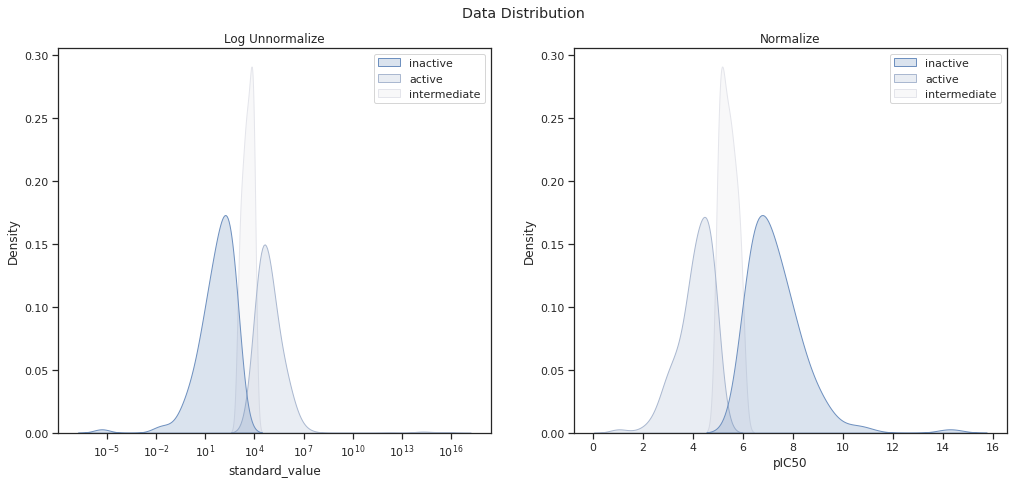

In [ ]:
fig, axs = plt.subplots(1, 2)
plt.tight_layout(pad=4)
fig.suptitle('Data Distribution')
sns.kdeplot(ax=axs[0], data=not_normalize, x='standard_value', hue=np.array(not_normalize.status),
            fill=True, bw_adjust=2, log_scale=True)
axs[0].set_title('Log Unnormalize')
sns.kdeplot(ax=axs[1], data=bioactivity_df, x='pIC50', hue=np.array(bioactivity_df.status), fill=True, bw_adjust=2)
axs[1].set_title('Normalize');

Although unormalize data has been logged, there are still extrme outliers. The data are much uniformlt distributed after normalized.

#### Bioactivity Classes Comparison

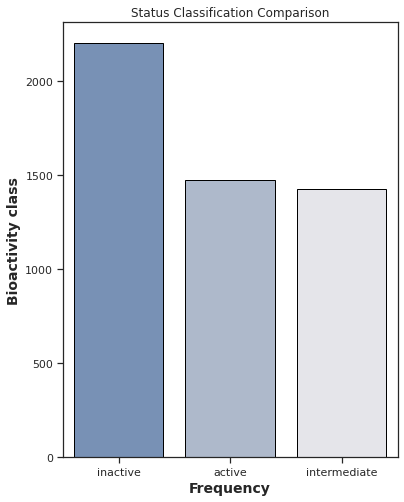

In [ ]:
plt.figure(figsize=(6, 8))
sns.countplot(x='status', data=bioactivity_df, edgecolor='black')
plt.xlabel('Frequency', fontsize=14, fontweight='bold')
plt.ylabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.title('Status Classification Comparison');

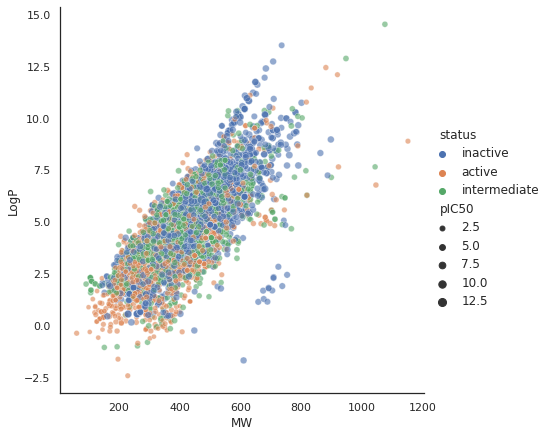

In [ ]:
sns.set_theme(style="white")
sns.relplot(x='MW', y='LogP', data=bioactivity_df, size='pIC50',
            hue='status', alpha=.6, height=6);

#### Descriptors Distribution Pairplot

In [ ]:
descs_df = bioactivity_df.drop(columns=['canonical_smiles'])

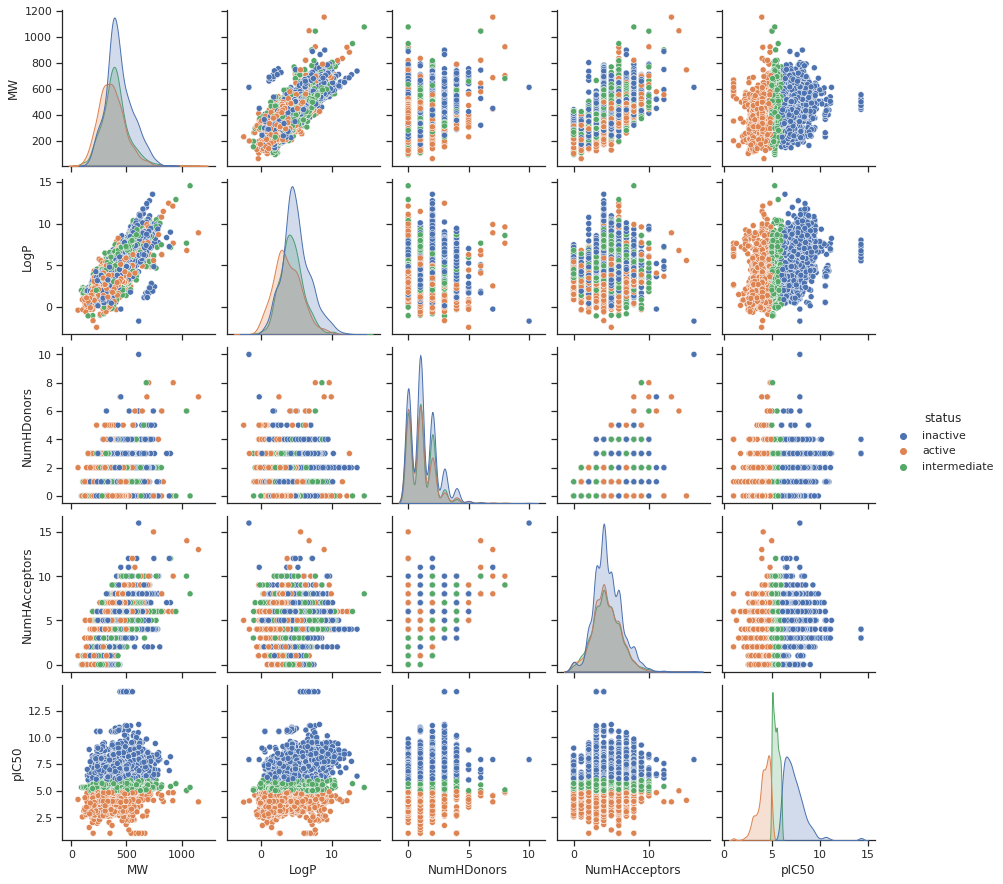

In [ ]:
sns.set_style("ticks")
fig = sns.pairplot(descs_df, hue='status');

####MW versus LogP Distribution

The jointplot illustrate 3 classes have similar chemical bases for LogP and MW Descriptors

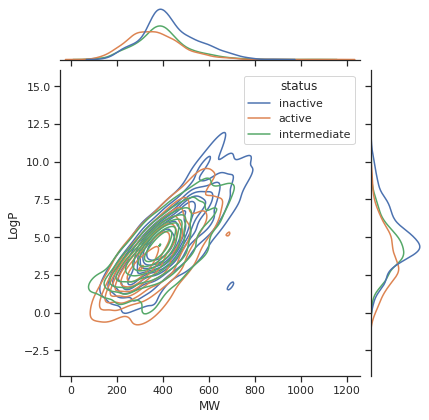

In [ ]:
sns.jointplot(data=bioactivity_df, x='MW', y='LogP', hue='status', kind='kde')
plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold');

#### Discriptors Value BoxPlot

In [ ]:
pIC50_df = pd.melt(bioactivity_df, id_vars=['pIC50', 'status'],
                   value_vars=["MW","LogP","NumHDonors","NumHAcceptors"])

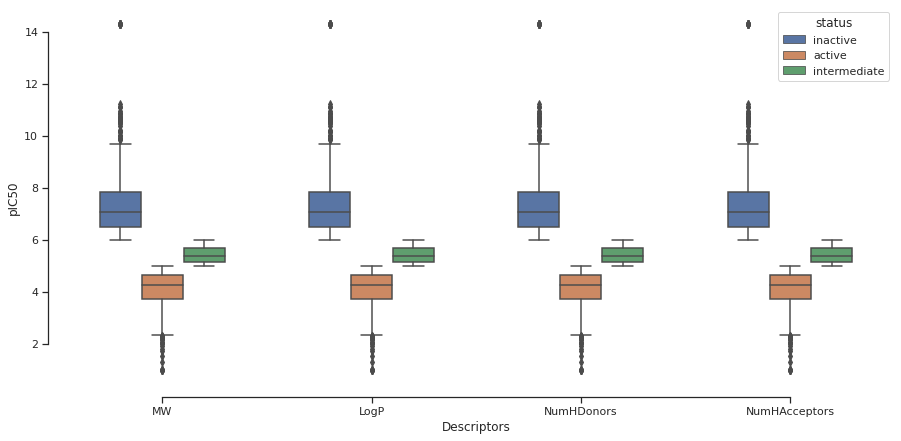

In [ ]:
sns.boxplot(data=pIC50_df, x='variable', y='pIC50', hue='status', width=0.6)
# sns.stripplot(data=pIC50_df, x='pIC50', y='variable', size=.9, color=".3", linewidth=0)
plt.xlabel('Descriptors')
sns.despine(offset=10, trim=True);

#### Statistical analysis | Calculate Nonparametric Statistical Hypothesis Tests

Using a nonparametric statistical tests to determine if data samples were drawn from populations with the `same` or `different distributions`.

The Kruskal-Wallis H and Friedman tests can be used for comparing more than two data samples.

ref: [Calculate Nonparametric Statistical Hypothesis with Python](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/)

In [ ]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import kruskal

In [ ]:
def statisticcal_test(bioactivity_df, descriptors):
  seed(1)

  result = {'descriptor': [], 'statistics': [], 'p_value': [],
            'alpha': [], 'interpretation': []}
  for descriptor in descriptors:

    selected_df = bioactivity_df[[descriptor, 'status']]

    active = selected_df[selected_df['status'] == 'active'][descriptor]
    inactive = selected_df[selected_df['status'] == 'inactive'][descriptor]
    intermediate = selected_df[selected_df['status'] == 'intermediate'][descriptor]

    stat, p_value = kruskal(active, inactive, intermediate)
    alpha = 0.05

    if p_value > alpha:
      interpretation = 'Same distribution (fail to reject H0)'
    if p_value <= alpha:
      interpretation = 'Different distribution (reject H0)'

    result['descriptor'].append(descriptor)
    result['p_value'].append(p_value)
    result['statistics'].append(stat)
    result['alpha'].append(alpha)
    result['interpretation'].append(interpretation)

  return pd.DataFrame(result)

In [ ]:
descriptors = ["pIC50", "MW","LogP","NumHDonors","NumHAcceptors"]
statisticcal_test(bioactivity_df, descriptors)

,descriptor,statistics,p_value,alpha,interpretation
0,pIC50,4457.714432,0.000000e+00,0.05,Different distribution (reject H0)
1,MW,271.863005,9.240566e-60,0.05,Different distribution (reject H0)
2,LogP,337.435258,5.331688e-74,0.05,Different distribution (reject H0)
3,NumHDonors,51.262016,7.389154e-12,0.05,Different distribution (reject H0)
4,NumHAcceptors,10.342159,5.678437e-03,0.05,Different distribution (reject H0)


MW & LogP Descriptors in Active Class

In [ ]:
active_df = bioactivity_df[bioactivity_df.status == 'active']

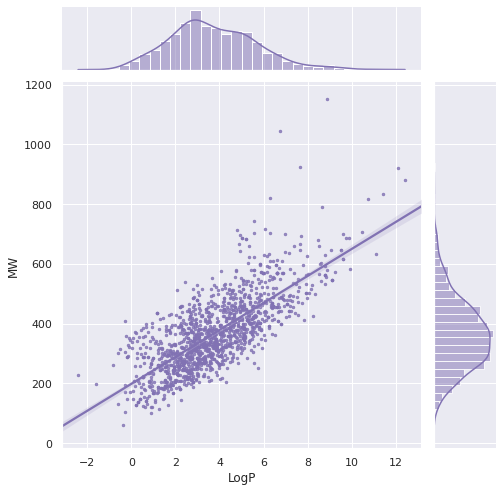

In [ ]:
sns.set_theme(style="darkgrid")
sns.jointplot(x="LogP", y="MW", data=active_df,
              kind="reg", truncate=False, color="m", height=7, scatter_kws={'s':6});

MW & LogP Descriptors in Inactive Class

In [ ]:
inactive_df = bioactivity_df[bioactivity_df.status == 'inactive']

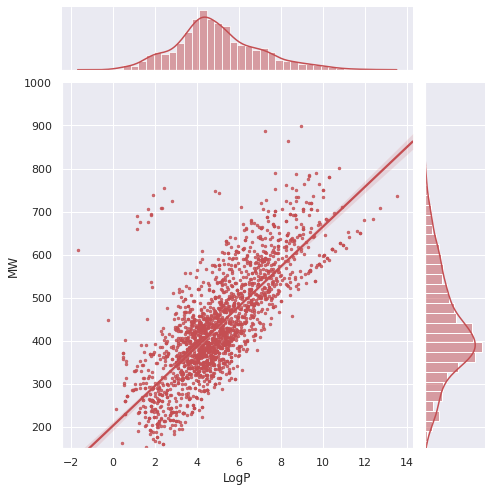

In [ ]:
sns.set_theme(style="darkgrid")
sns.jointplot(x="LogP", y="MW", data=inactive_df, ylim=(150, 1000),
              kind="reg", truncate=False, color="r", height=7, scatter_kws={'s':6});

**MW & LogP Descriptors in Intermediate Class**

In [ ]:
intermediate_df = bioactivity_df[bioactivity_df.status == 'intermediate']

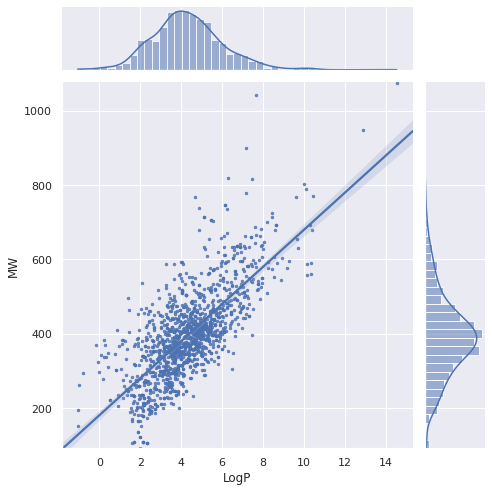

In [ ]:
sns.set_theme(style="darkgrid")
sns.jointplot(x="LogP", y="MW", data=intermediate_df, ylim=(92, 1076),
              kind="reg", truncate=False, color="b", height=7, scatter_kws={'s':6});

**Conculsion:**

- **pIC50 values** obviously shown a different distribution due to the initial classification made based on standard_value

- All **4 Lipinski's descriptors** resulted in a **statistical difference** between three classes: **inactive, active, intermediate**

#### Correlation Matrix

In [ ]:
corr_matrix = bioactivity_df.corr()

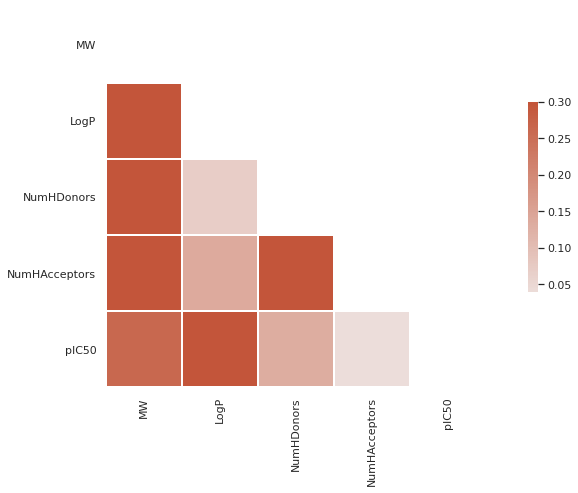

In [ ]:
sns.set_theme(style="white")
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, vmax=.3, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

### Save file to Google Drive

In [ ]:
bioactivity_df.to_csv('bioactivity_data.csv', index=False)

In [ ]:
!mkdir "/content/drive/MyDrive/Colab Notebooks/Bioinformatics Project"

mkdir: cannot create directory ‘/content/drive/MyDrive/Colab Notebooks/Bioinformatics Project’: File exists


In [ ]:
!cp bioactivity_data.csv "/content/drive/MyDrive/Colab Notebooks/Bioinformatics Project"
!ls -l "/content/drive/MyDrive/Colab Notebooks/Bioinformatics Project"

total 925
-rw------- 1 root root 685050 Aug  3 05:12 bioactivity_data.csv
-rw------- 1 root root 261751 Aug  3 05:12 Computational_Drug_Discovery_Part1.ipynb
